## Download testing data

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import driveanon

In [60]:
%%capture
driveanon.save('13agtkTBW9HydkjwnquIt6axiDvbg1D9p', filename='data.tar.gz')
! tar -xzvf data.tar.gz
! rm data.tar.gz

## Plot difference maps

In [4]:
import os
from pathlib import Path
import glacierpoly as gpoly
import glob
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from shapely.ops import nearest_points
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.io import imshow
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
from rasterstats import zonal_stats
from rasterio.plot import show
from rasterio import mask

import warnings
warnings.filterwarnings('ignore')

In [5]:
ls data/gl*

ls: cannot access 'data/gl*': No such file or directory


In [6]:
! rm data/gl*

rm: cannot remove 'data/gl*': No such file or directory


In [7]:
# rm data/glacier_outline_detected_1977-10-03.geojson

In [8]:
next_reference_polygon = 'data/south_cascade_rgi_polygon.geojson'

if sorted(glob.glob('data/glacier_outline_full_*')):
    next_reference_polygon = sorted(glob.glob('data/glacier_outline_full_*'))[-1]
    
next_reference_polygon

'data/south_cascade_rgi_polygon.geojson'

In [9]:
diffs = sorted(glob.glob('data/diff*.tif'))
gdf = gpd.read_file(next_reference_polygon)

In [10]:
len(diffs)

17

In [11]:
'''
skip erode islands for 
'data/diff_dem_ref_1970-09-29.tif' # diffs[0]
'data/diff_dem_ref_1979-10-06.tif' # diffs[4]

this one is bad and has too much noise for this too work
'data/diff_dem_ref_1974-08-10.tif' # diffs[1] 

the rest work with defaults
''';

In [12]:
dod = diffs[0]
dod

'data/diff_dem_ref_1970-09-29.tif'

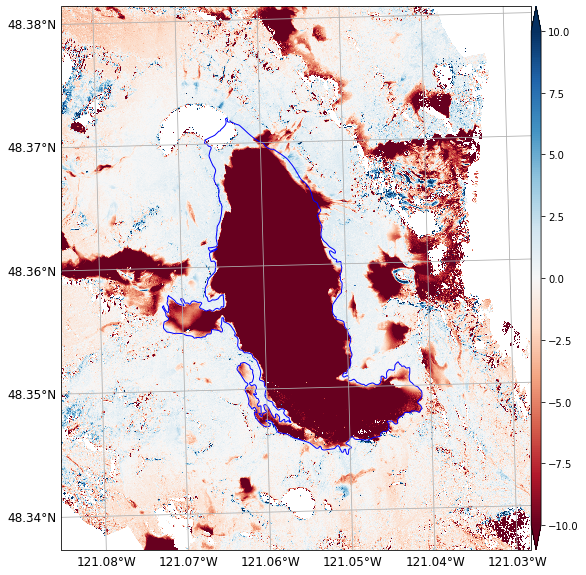

In [13]:
gpoly.plotting.plot_tif(dod, 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')

## Detect edges

In [14]:
def multi_dil(im, num, window):
    for i in range(num):
        im = dilation(im, window)
    return im
def multi_ero(im, num, window):
    for i in range(num):
        im = erosion(im, window)
    return im

def replace_and_fill_nodata_value(array, nodata_value, fill_value):
    if np.isnan(nodata_value):
        masked_array = np.nan_to_num(array, nan=fill_value)
    else:
        mask = array == nodata_value
        masked_array = np.ma.masked_array(array, mask=mask)
        masked_array = np.ma.filled(masked_array, fill_value=fill_value)

    return masked_array

## clip raster with buffer around input glacier polygon
- handles DoD mosaics capturing multiple glaciers
- idea is to run this iteratively over RGI polygon to get new polygon for each glacier

In [15]:
buffer = gdf.buffer(2000)

source = rasterio.open(dod,masked=True)
# array = source.read(1)

rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
masked_array, transform = rasterio.mask.mask(source, buffer)
array = masked_array.squeeze()

array = replace_and_fill_nodata_value(array, source.nodata, 0)

## might be useful
# array = cv2.bilateralFilter(array,21,75,75)
# array = cv2.GaussianBlur(array, (9,9), 0)

## might be desired
# mask = array > -2
# array = np.ma.masked_array(array, mask=mask)
# array = np.ma.filled(array, fill_value=0)

array = np.uint8(array)

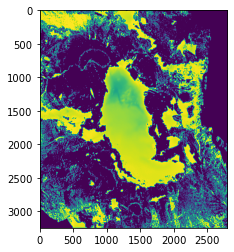

In [16]:
plt.imshow(array)

## erode islands
- this step is overkill for two of the examples, but necessary for the rest

In [17]:
# window = np.ones((9,9)).astype(int)
# array = opening(array, window)

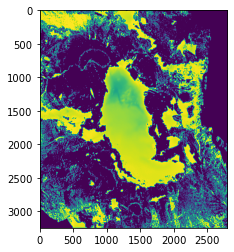

In [18]:
plt.imshow(array)

## detect edges

In [19]:
canny = cv2.Canny(array,50,150)

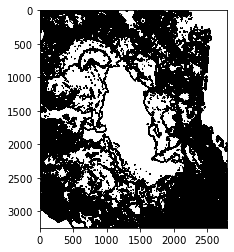

In [20]:
plt.imshow(canny,cmap='Greys',vmax=1);

## dilate edges
- can modify this window size to enhance connectedness

In [21]:
window = np.ones((3,3)).astype(int)
multi_dilated = multi_dil(canny, 4,window)

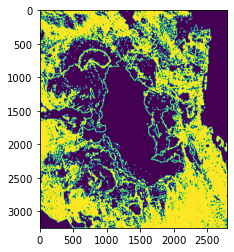

In [22]:
plt.imshow(multi_dilated)

## close areas
- 1E6 as per trial and error

In [23]:
area_closed = area_closing(multi_dilated, 1E6)

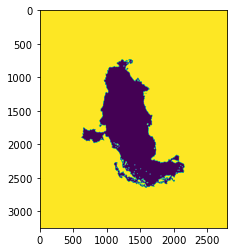

In [24]:
plt.imshow(area_closed)

## label areas

In [25]:
label_im = label(area_closed)
regions = regionprops(label_im)

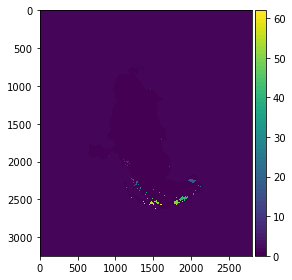

In [26]:
imshow(label_im,cmap=plt.cm.get_cmap('viridis', len(regions)))

## get stats
- other blobs with large area may be of interest
- right now only extracting largest DoD blob (the glacier)

In [27]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation']
df = pd.DataFrame(regionprops_table(label_im, array, 
             properties=properties))

In [28]:
df.sort_values(by=['area'], ascending=False).head()

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation
0,7954445,9107392,9107392,0.873405,67.123031,0.873405,0.488618,-0.039511
40,3521,4655,5858,0.601058,214.276626,0.756391,0.869957,-1.342038
16,3366,3676,5148,0.653846,95.374629,0.915669,0.883784,1.391245
48,2995,3819,5016,0.597089,202.173957,0.784237,0.838544,-1.496675
54,1747,2075,2912,0.599931,179.149971,0.841928,0.805966,0.878216


## get largest region

In [29]:
max_area_index = df[df['area'] == df['area'].max()].index[0]
if max_area_index == 0:
    pass
else:
    max_area_index = max_area_index + 1

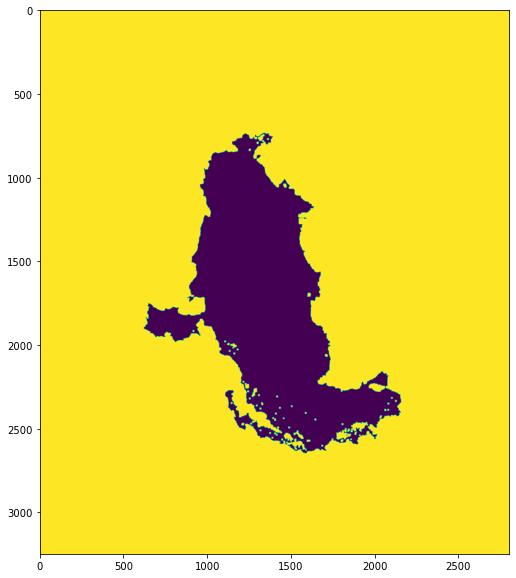

In [30]:
mask = label_im != max_area_index
masked_array = np.ma.masked_array(label_im, mask=mask)
masked_array = np.ma.filled(masked_array, fill_value=1)
masked_array = masked_array.astype(np.uint8)
fig,ax=plt.subplots(figsize=(10,10))
ax.imshow(masked_array)

## write to geotiff

In [31]:
! rm tmp.tif
! rm -rf tmp.geojson

rm: cannot remove 'tmp.tif': No such file or directory


In [32]:
with rasterio.open(
    'tmp.tif',
    'w',
    driver='GTiff',
    height=masked_array.shape[0],
    width=masked_array.shape[1],
    count=1,
    nodata=1,
    dtype=masked_array.dtype,
    crs=source.crs,
    transform=source.transform,
) as dst:
    dst.write(masked_array, 1)

In [33]:
# need inverse of what first polygonize operation gives... might be a better way to do this
! gdal_polygonize.py tmp.tif tmp.geojson
! gdal_rasterize -burn 1 -tr {source.res[0]} {source.res[0]} -a_nodata 0 -add tmp.geojson tmp.tif
! gdal_polygonize.py tmp.tif tmp.geojson

Several drivers matching geojson extension. Using GeoJSON
Creating output tmp.geojson of format GeoJSON.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Several drivers matching geojson extension. Using GeoJSON
0...10...20...30...40...50...60...70...80...90...100 - done.


In [34]:
gdf_new = gpd.read_file('tmp.geojson', driver='GeoJSON')
gdf_new = gdf_new[gdf_new.intersects(gdf.geometry[0])]
gdf_new = gdf_new[gdf_new.area == gdf_new.area.max()]
gdf_new['geometry'] = Polygon(gdf_new['geometry'].iloc[0].exterior)

## clip areas outside boundary unless positive (glacier advanced)
- this should probably come after merging

In [35]:
diff = gpd.overlay(gdf_new, gdf, how='difference')
diff = diff.explode().reset_index().iloc[: , 2:]

diff_stats = zonal_stats(diff, dod)
mean_dods = []
for i in diff_stats:
    mean_dods.append(i['mean'])
    
diff['mean_dod'] = mean_dods

negative_elev_change_regions = diff[diff['mean_dod'] < 0]
gdf_new = gpd.overlay(gdf_new, negative_elev_change_regions, how='difference')

In [36]:
gdf_new = gdf_new.explode().reset_index().iloc[: , 2:]
mask = gdf_new.area > 5
gdf_new = gdf_new.loc[mask]
gdf_new = gdf_new.dissolve()

In [37]:
def connect_and_dissolve_multipolygon_gdf(multipolygon_gdf):
    '''
    Take geopandas dataframe with single multipolygon and
    merges into single polygon by inserting adjacent polygon 
    coordinates at nearest vertex. Fuses smaller polygon to 
    largest polygon in multipolygon object.
    '''
    
    # explode multipolygon
    gdf_tmp = multipolygon_gdf.explode().reset_index().iloc[: , 2:]
    
    # find largest polygon
    areas = []
    gdfs = []
    for i,v in enumerate(gdf_tmp.index):
        tmp = gdf_tmp[gdf_tmp.index == i]
        areas.append(tmp.area.values[0])
        gdfs.append(gdf_tmp[gdf_tmp.index == i])
    gdf_tmp['area'] = areas
    
    # seperate into geodataframes
    largest_polygon = gdf_tmp.sort_values(by=['area'],ascending=False).iloc[0]
    largest_polygon = pd.DataFrame(largest_polygon).T
    largest_polygon = gpd.GeoDataFrame(largest_polygon, geometry = 'geometry')
    small_polygons  = gdf_tmp.sort_values(by=['area'],ascending=False).iloc[1:]
    small_polygons  = gpd.GeoDataFrame(small_polygons, geometry = 'geometry')
    
    largest_polygon_geom = largest_polygon['geometry'].iloc[0]
    print(len(small_polygons.index))

    for i,v in enumerate(small_polygons.index): 
        small_polygon_geom = small_polygons['geometry'].iloc[i]

        tolerance = 10
        for i in range(50):
            geom_snapped = shapely.ops.snap(largest_polygon_geom, 
                                            small_polygon_geom, 
                                            tolerance)

            if geom_snapped.area < largest_polygon_geom.area:
                tolerance = tolerance + 10
            else:
                print('geometry snapped at', tolerance, 'm')    

                # create polygon
                largest_polygon_updated = gpd.GeoDataFrame({'geometry': [geom_snapped]})

                # update geometry of largest polygon
                largest_polygon_geom = largest_polygon_updated['geometry'].iloc[0]
                break

    return largest_polygon_updated
    

In [38]:
if isinstance(gdf_new['geometry'].iloc[0],
              type(shapely.geometry.multipolygon.MultiPolygon())):
    print('not a single polygon')
    gdf_new = connect_and_dissolve_multipolygon_gdf(gdf_new)

In [39]:
if isinstance(gdf_new['geometry'].iloc[0],
              type(shapely.geometry.polygon.Polygon())):
    print('is single polygon')

is single polygon


<AxesSubplot:>

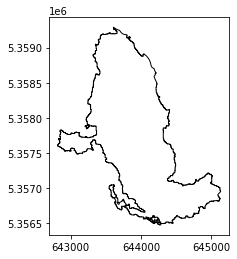

In [40]:
gdf_new.plot(facecolor='none',edgecolor='k')

In [41]:
p = str(Path(dod).parent.resolve())
n = str(Path(dod).stem)
out = os.path.join(p,'glacier_outline_detected_'+ n.split('_')[-1] +'.geojson')

gdf_new.to_file(out, driver='GeoJSON')

'data/diff_dem_ref_1970-09-29.tif'

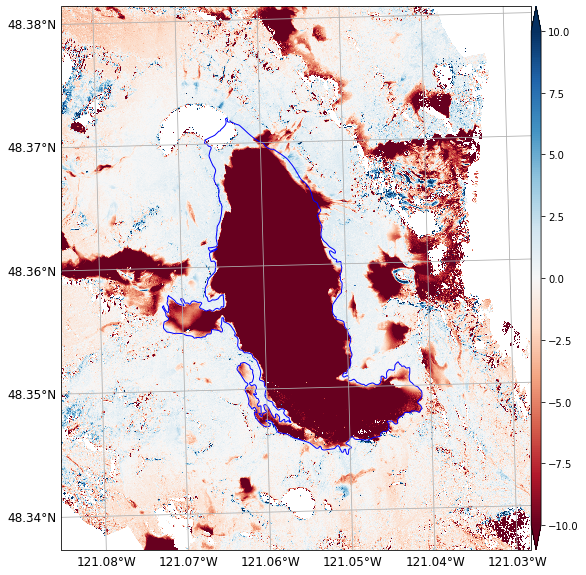

In [42]:
gpoly.plotting.plot_tif(dod, 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
dod

'data/diff_dem_ref_1970-09-29.tif'

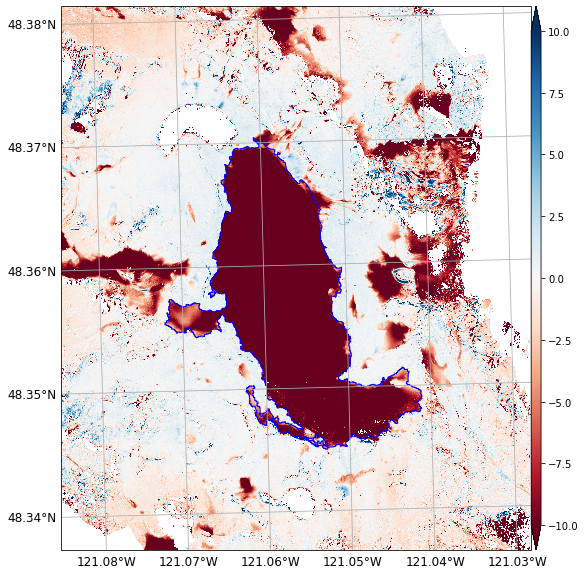

In [43]:
gpoly.plotting.plot_tif(dod, 
                        glacier_outline_gdf=gdf_new, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
dod

## merge with existing (ideally previous) glacier polygon

#### get max elevation in detected glacierized area

In [44]:
dem = 'data/reference_dem_2013-2015_WV_composite.tif'
max_caputed_elevation = zonal_stats(out, dem)[0]['max']

#### find areas in existing glacier polygon above max captured elevation

In [45]:
res_union = gpd.overlay(gdf, gdf_new, how='difference')
res_union = res_union.explode()
res_union = res_union.reset_index().iloc[: , 2:]
res_union = res_union[['geometry']]

In [46]:
stats = zonal_stats(res_union, dem)
max_elevations = []
for i in stats:
    max_elevations.append(i['max'])

In [47]:
res_union['max_elevations'] = max_elevations

#### merge where elevations are higher

In [48]:
remaining_area = res_union[res_union['max_elevations'] > max_caputed_elevation]

In [49]:
remaining_area

,geometry,max_elevations
14,"POLYGON ((644834.518 5356677.229, 644835.299 5...",2210.662842
39,"POLYGON ((643738.301 5356722.711, 643744.039 5...",2204.231445
56,"POLYGON ((643094.646 5357484.092, 643089.048 5...",2262.402588


<AxesSubplot:>

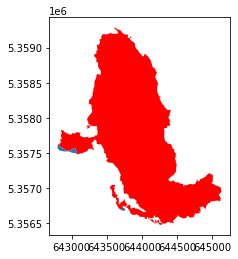

In [50]:
fig,ax = plt.subplots()
gdf_new.plot(ax=ax,color='r')
remaining_area.plot(ax=ax,aspect=1)

In [51]:
merged = gdf_new.geometry.append(remaining_area.geometry)
merged = gpd.GeoDataFrame(geometry=merged).reset_index(drop=True)
merged = merged.dissolve()

In [52]:
merged = merged.explode().reset_index().iloc[: , 2:]
geoms = []
for i in range(0,len(merged)):
    geoms.append(Polygon(merged['geometry'].iloc[i].exterior))
merged['geometry'] = geoms

<AxesSubplot:>

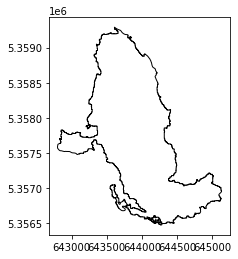

In [53]:
merged = merged.dissolve()
merged.plot(facecolor='none',edgecolor='k')

## fuse into single polygon in case multipolygon

In [54]:
if isinstance(merged['geometry'].iloc[0],
              type(shapely.geometry.multipolygon.MultiPolygon())):
    print('not a single polygon')
    merged = connect_and_dissolve_multipolygon_gdf(merged)
    

In [55]:
if isinstance(merged['geometry'].iloc[0],
              type(shapely.geometry.polygon.Polygon())):
    print('is single polygon')

is single polygon


## write to disk

In [56]:
p = str(Path(dod).parent.resolve())
n = str(Path(dod).stem)
out = os.path.join(p,'glacier_outline_full_'+ n.split('_')[-1] +'.geojson')

In [57]:
merged.to_file(out, driver='GeoJSON')